In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")
cmap = "viridis"

In [3]:
# ==============================
# PARAMETERS
# ==============================

TargetWealth = 49.5 / 0.035
retirementAge = 67
risk_aversion = 0.02

initialBalance = np.array([500, 400, 900, 500, 1100, 950])
currentAge = np.array([52, 55, 57, 57, 62, 65])

youngestAge = currentAge.min()
numYears = retirementAge - youngestAge

savings = 0.16 * (60 + 67 - np.arange(15, 0, -1) - 27)

balanceGrid = np.arange(50, 2 * TargetWealth + 1, 10)

Seed = 54321
sampleSizeForSolving = 20
sampleSizeForSimulating = 50

np.random.seed(Seed)

initialBalance = initialBalance + savings[currentAge - youngestAge]

In [4]:
# ==============================
# UTILITY FUNCTION
# ==============================

def Utility(wealth):
    wealth = np.array(wealth)
    return np.where(
        wealth > 1.2 * TargetWealth,
        (1.2 * TargetWealth)**0.2 * wealth**0.8,
        np.where(
            wealth > 0.8 * TargetWealth,
            wealth - risk_aversion * (1.2 * TargetWealth - wealth)**2,
            -15840 + 15 * wealth - risk_aversion * (1.2 - 0.8)**2 * TargetWealth**2
        )
    )

In [5]:
# ==============================
# RETURNS
# ==============================

assetExpectedReturns = np.array([0.06, 0.059, 0.07, 0.056, 0.019, 0.052, 0.015])
assetStdevs = np.array([0.191, 0.202, 0.268, 0.207, 0.038, 0.07, 0.058])

assetCorrel = np.array([
[1.00,0.74,0.67,0.74,0.13,0.47,0.02],
[0.74,1.00,0.70,0.78,0.09,0.46,0.00],
[0.67,0.70,1.00,0.66,0.07,0.45,-0.03],
[0.74,0.78,0.66,1.00,0.10,0.37,-0.03],
[0.13,0.09,0.07,0.10,1.00,0.10,0.10],
[0.47,0.46,0.45,0.37,0.10,1.00,0.55],
[0.02,0.00,-0.03,-0.03,0.10,0.55,1.00]
])

assetCovar = np.diag(assetStdevs) @ assetCorrel @ np.diag(assetStdevs)

mixWeights = np.array([
[0.30,0.30,0.10,0.10,0.10,0.10,0.00],
[0.25,0.25,0.10,0.10,0.20,0.10,0.00],
[0.25,0.21,0.08,0.08,0.30,0.08,0.00],
[0.23,0.19,0.06,0.06,0.40,0.06,0.00],
[0.21,0.15,0.04,0.05,0.45,0.05,0.05],
[0.16,0.12,0.04,0.04,0.50,0.04,0.10],
[0.13,0.09,0.02,0.03,0.55,0.03,0.15],
[0.08,0.06,0.01,0.02,0.51,0.02,0.30]
])

normSample_solve = np.random.multivariate_normal(
    assetExpectedReturns, assetCovar, sampleSizeForSolving
)
mixSample_solve = normSample_solve @ mixWeights.T

normSample_simulate = np.random.multivariate_normal(
    assetExpectedReturns, assetCovar,
    sampleSizeForSimulating * numYears
)
mixSample_simulate = normSample_simulate @ mixWeights.T

In [6]:
# ==============================
# LOOKUPS
# ==============================

def LookupEUtil(wealth, reference_year):
    nextYearSolution = solutionTable[solutionTable.year == reference_year]
    balances = nextYearSolution.balance.values
    idx = np.abs(balances - wealth[:, None]).argmin(axis=1)
    return nextYearSolution.expUtil.values[idx]

def LookupDecision(wealth, reference_year):
    nextYearSolution = solutionTable[solutionTable.year == reference_year]
    balances = nextYearSolution.balance.values
    idx = np.abs(balances - wealth).argmin()
    return nextYearSolution.bestMix.values[idx]


In [7]:
# ==============================
# DYNAMIC PROGRAMMING
# ==============================

def EvaluateStates(yearSolution):
    thisYear = yearSolution.year.iloc[0]
    results = []

    for wvalue in yearSolution.balance:
        temp = wvalue * (1 + mixSample_solve) + savings[thisYear]

        Scores = np.array([
            LookupEUtil(temp[:, j], thisYear + 1)
            for j in range(temp.shape[1])
        ]).T

        expected_util = Scores.mean(axis=0)
        best_decision = np.argmax(expected_util)

        results.append({
            "year": thisYear,
            "balance": wvalue,
            "expUtil": expected_util[best_decision],
            "bestMix": best_decision + 1
        })

    return pd.DataFrame(results)

solutionTable = pd.DataFrame({
    "year": numYears,
    "balance": balanceGrid
})

solutionTable["expUtil"] = Utility(solutionTable.balance)
solutionTable["bestMix"] = -1

for nyear in range(numYears - 1, -1, -1):
    yearSolution = pd.DataFrame({
        "year": nyear,
        "balance": balanceGrid
    })
    yearSolution = EvaluateStates(yearSolution)
    solutionTable = pd.concat([solutionTable, yearSolution], ignore_index=True)

In [8]:
# ==============================
# SIMULATION
# ==============================

Simulations = []

for nclient in range(len(initialBalance)):

    startingYear = currentAge[nclient] - youngestAge
    initBal = initialBalance[nclient]

    bestDecision = LookupDecision(initBal, startingYear)

    Projection = [{
        "clientNumber": nclient + 1,
        "year": startingYear,
        "balance": initBal,
        "bestMix": bestDecision,
        "pathNum": p
    } for p in range(sampleSizeForSimulating)]

    for nyear in range(startingYear + 1, numYears + 1):
        new_entries = []

        for p in range(sampleSizeForSimulating):

            parent = Projection[-sampleSizeForSimulating + p]
            mix_choice = parent["bestMix"] - 1

            ret = 1 + mixSample_simulate[
                sampleSizeForSimulating * (nyear - startingYear - 1) + p,
                mix_choice
            ]

            new_balance = ret * parent["balance"] + savings[nyear - 1]
            new_decision = LookupDecision(new_balance, nyear)

            new_entries.append({
                "clientNumber": nclient + 1,
                "year": nyear,
                "balance": new_balance,
                "bestMix": new_decision,
                "pathNum": p
            })

        Projection.extend(new_entries)

    Simulations.extend(Projection)

Simulations = pd.DataFrame(Simulations)

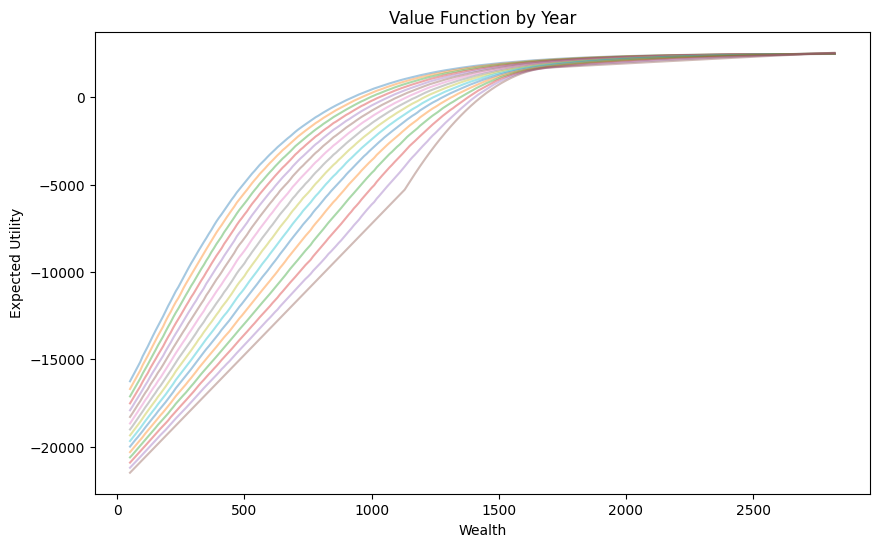

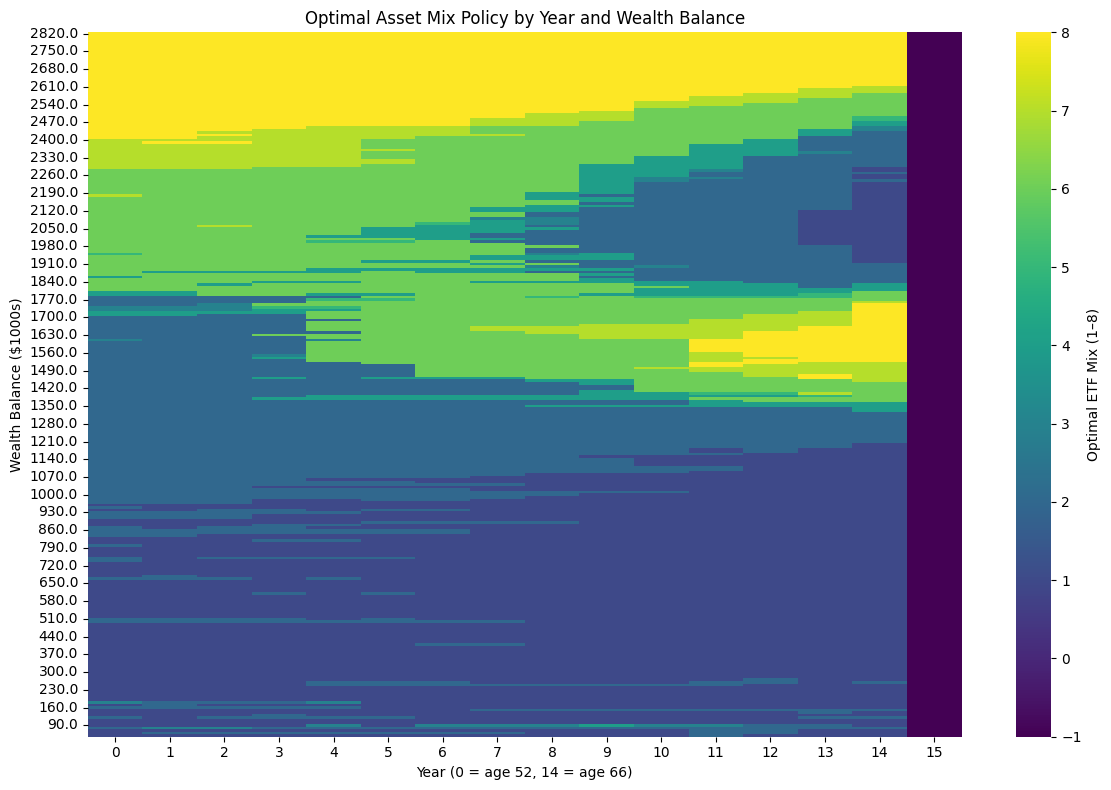

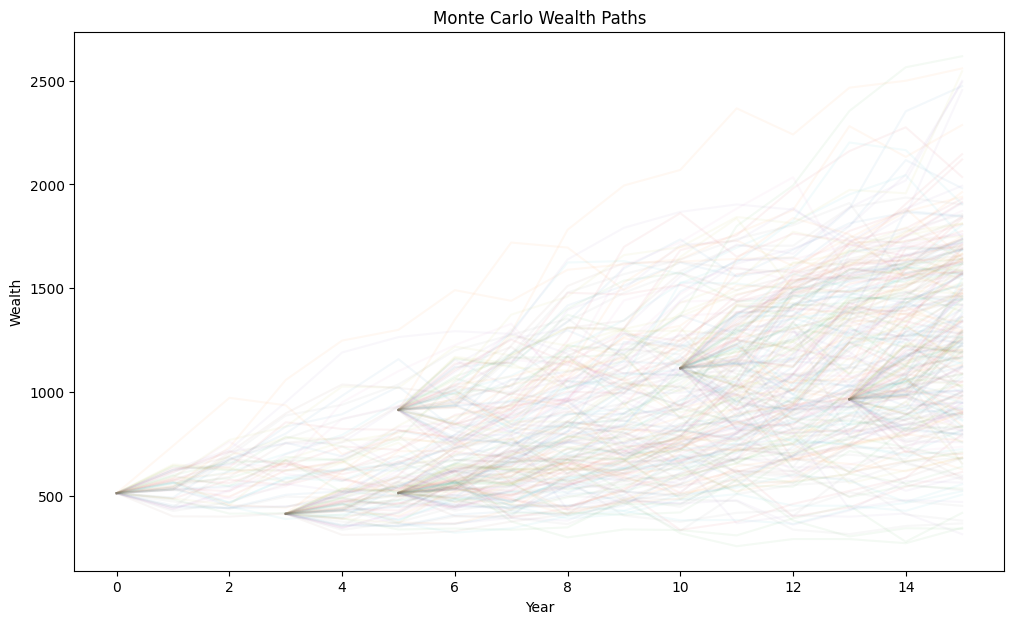

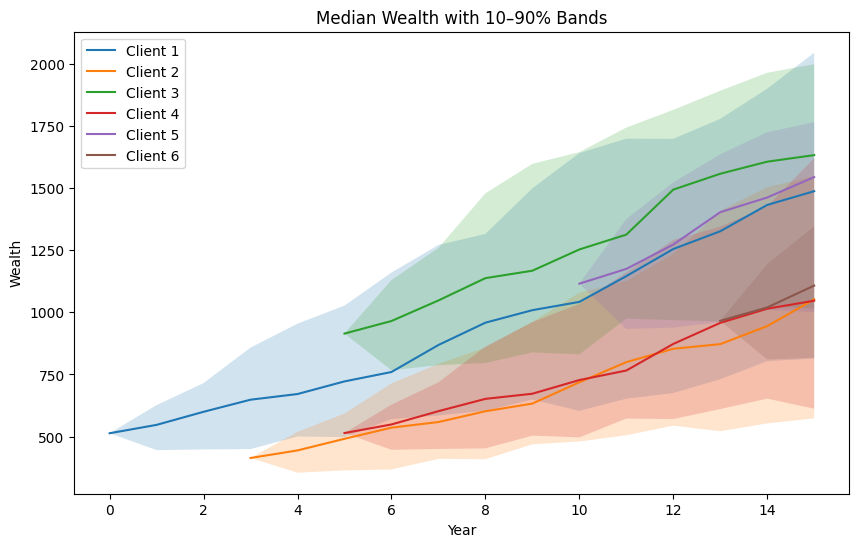

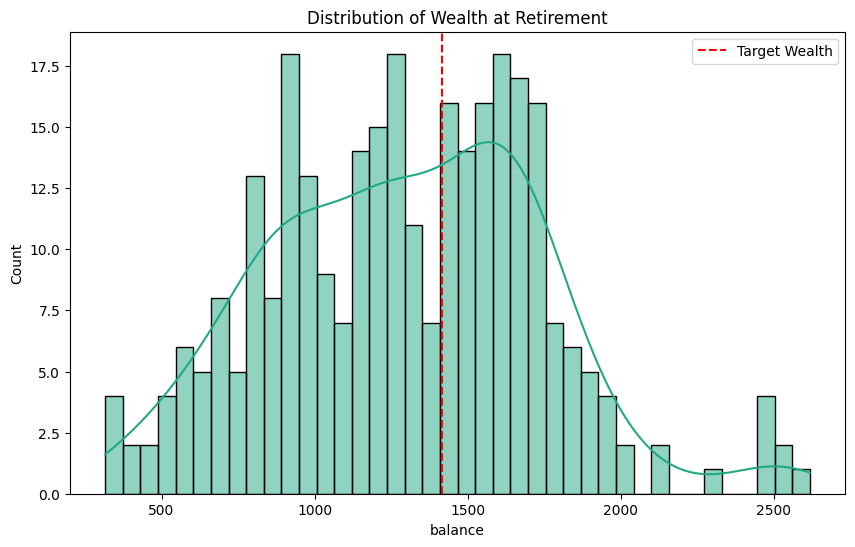

Probability of reaching target wealth: 0.4333


In [9]:
# Value Function
plt.figure(figsize=(10,6))
for y in sorted(solutionTable.year.unique()):
    subset = solutionTable[solutionTable.year == y]
    plt.plot(subset.balance, subset.expUtil, alpha=0.4)
plt.title("Value Function by Year")
plt.xlabel("Wealth")
plt.ylabel("Expected Utility")
plt.show()

# POLICY HEATMAP
policy_matrix = solutionTable.pivot(
    index="balance",
    columns="year",
    values="bestMix"
).sort_index()

policy_matrix = policy_matrix.iloc[::-1]

plt.figure(figsize=(12,8))

sns.heatmap(
    policy_matrix,
    cmap=cmap,
    cbar_kws={'label': 'Optimal ETF Mix (1–8)'}
)

plt.title("Optimal Asset Mix Policy by Year and Wealth Balance")
plt.xlabel("Year (0 = age {}, {} = age {})".format(
    youngestAge, numYears-1, retirementAge-1
))
plt.ylabel("Wealth Balance ($1000s)")

plt.tight_layout()
plt.show()


# Simulation Paths
plt.figure(figsize=(12,7))
for client in Simulations.clientNumber.unique():
    subset = Simulations[Simulations.clientNumber == client]
    for p in subset.pathNum.unique():
        path = subset[subset.pathNum == p]
        plt.plot(path.year, path.balance, alpha=0.05)
plt.title("Monte Carlo Wealth Paths")
plt.xlabel("Year")
plt.ylabel("Wealth")
plt.show()

# Median + Bands
plt.figure(figsize=(10,6))
for client in Simulations.clientNumber.unique():
    subset = Simulations[Simulations.clientNumber == client]
    grouped = subset.groupby("year")["balance"]
    median = grouped.median()
    p10 = grouped.quantile(0.1)
    p90 = grouped.quantile(0.9)
    plt.plot(median.index, median.values, label=f"Client {client}")
    plt.fill_between(median.index, p10, p90, alpha=0.2)
plt.title("Median Wealth with 10–90% Bands")
plt.xlabel("Year")
plt.ylabel("Wealth")
plt.legend()
plt.show()

# Retirement Distribution
retirement_data = Simulations[Simulations.year == numYears]
plt.figure(figsize=(10,6))
sns.histplot(retirement_data.balance, bins=40, kde=True, color=plt.cm.viridis(0.6))
plt.axvline(TargetWealth, color='red', linestyle='--', label="Target Wealth")
plt.title("Distribution of Wealth at Retirement")
plt.legend()
plt.show()

prob_success = (retirement_data.balance >= TargetWealth).mean()
print("Probability of reaching target wealth:", round(prob_success,4))
